## Лабораторная работа №2

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils

Будем использовать МНИСТ из датасета Кераса

Разбиение и нормализация данных:

In [34]:
batch_size = 128
nb_classes = 10
nb_epoch = 20

(train_set, train_labels), (test_set, test_labels) = mnist.load_data()

train_set = train_set.reshape(60000, 784)
test_set = test_set.reshape(10000, 784)

train_set = train_set.astype('float32')
test_set = test_set.astype('float32')
train_set /= 255
test_set /= 255
print(train_set.shape[0], 'train samples')
print(test_set.shape[0], 'test samples')

train_labels = np_utils.to_categorical(train_labels, nb_classes)
test_labels = np_utils.to_categorical(test_labels, nb_classes)

60000 train samples
10000 test samples


Добавляем столбец единичек

In [35]:
train_set = np.append(train_set, np.ones((train_set.shape[0], 1)), axis=1)
test_set = np.append(test_set, np.ones((test_set.shape[0], 1)), axis=1)

Функция вычисления Софтмакс (используя "фишку")

In [5]:
def softmax(weights, train_set):
    probabilities = weights.dot(train_set.T)
    probabilities = np.exp(probabilities - probabilities.max(0))
    probabilities /= probabilities.sum(0)
    return probabilities

Вычисление градиента по весам функции Софтмакс

У нас размер батча m, метки принимают K значений
$$-1/m\sum_{i=1}^m\sum_{k=1}^K [y^{(i)}=k] * ln(\frac{exp(w^{(k)}x^{(i)})}{\sum_{j=1}^K{exp(w^{(j)}x^{(i)})}}) = -1/m\sum_{i=1}^m\sum_{k=1}^K [y^{(i)}=k] * (ln({exp(w^{(k)}x^{(i)})}) - ln({\sum_{j=1}^K{exp(w^{(j)}x^{(i)})}})) = $$

$$= -1/m\sum_{i=1}^m\sum_{k=1}^K [y^{(i)}=k] * (w^{(k)}x^{(i)} - ln({\sum_{j=1}^K{exp(w^{(j)}x^{(i)})}}))$$


Берем производную по $w^{(t)}$


$$-1/m\sum_{i=1}^m\sum_{k=1}^K [y^{(i)}=k] * (x^{(i)} - \frac{exp(w^{(t)}x^{(i)})x^{(i)}}{\sum_{j=1}^K{exp(w^{(j)}x^{(i)})}}) = -1/m\sum_{i=1}^m\sum_{k=1}^K [y^{(i)}=k] * (1 - \frac{exp(w^{(t)}x^{(i)})}{\sum_{j=1}^K{exp(w^{(j)}x^{(i)})}})x^{(i)} = $$
$$= 1/m\sum_{i=1}^m (p([y^{(i)}= t]) - [y^{(i)}=k])x^{(i)}$$

Или в матричной форме:

In [6]:
def softmax_grad(weights, input_set, labels):
    probabilities = softmax(weights, input_set)
    probabilities -= labels.T
    grad = probabilities.dot(input_set) / len(input_set)
    return grad

Функция, проверяющая качество нашего предсказания на отложенной выборке

In [7]:
def check_quality(weights, train_set, labels):
    probabilities = softmax(weights, train_set)
    predicted = np.argmax(probabilities, axis=0) - np.argmax(labels, axis=1)
    predicted = predicted != 0
    return np.sum(predicted)

Простой стохастический спуск (размер батча определен выше)

In [45]:
def iter_grad_desc(train_set, train_labels, test_set, test_labels, grad, ITERS, LMBD):
    path = []
    weights = np.zeros((10, train_set.shape[1]))
    for i in range(ITERS):
        temp_pos = 0
        while temp_pos + batch_size < len(train_set):
            gradient = grad(weights, train_set[temp_pos : temp_pos + batch_size], train_labels[temp_pos : temp_pos + batch_size])
            weights -= LMBD * gradient
            temp_pos += batch_size
        path.append(check_quality(weights, test_set, test_labels))
#       print(i, path[-1])
    return weights, path

In [46]:
w, p = iter_grad_desc(train_set, train_labels, test_set, test_labels, softmax_grad, 100, 0.5)

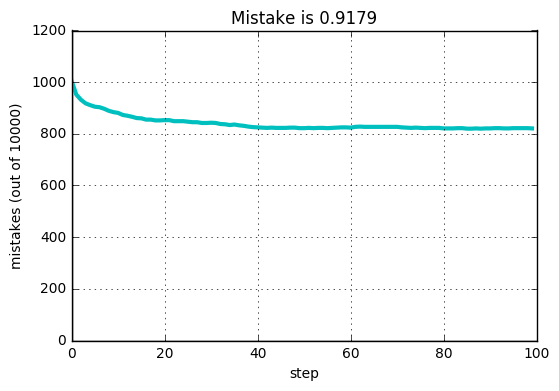

In [47]:
plt.grid(True)
plt.title('Mistake is ' + str(1 - p[-1] / len(test_set)))
plt.axhline(0, color="black")
plt.xlabel('step')
plt.axvline(0, color="black")
plt.ylabel('mistakes (out of ' + str(len(test_labels)) + ')')
plt.plot(np.array(range(len(p))), p, 'c', linewidth=3)
plt.show()

Подберем параметры регуляризации

In [72]:
def reg_iter_grad_desc(train_set, train_labels, test_set, test_labels, grad, ITERS, learning_rate, LMBD1, LMBD2):
    path = []
    weights = np.zeros((10, train_set.shape[1]))
    for i in range(ITERS):
        temp_pos = 0
        while temp_pos + batch_size < len(train_set):
            gradient = grad(weights, train_set[temp_pos : temp_pos + batch_size], train_labels[temp_pos : temp_pos + batch_size])
            weights -= learning_rate * gradient + LMBD1 * np.sign(weights) + 2 * LMBD2 * weights
            temp_pos += batch_size
        path.append(check_quality(weights, test_set, test_labels))
#       print(i, path[-1])
    return weights, path

In [73]:
lms = np.linspace(0, 1, num=10, endpoint=True)

X, Y = np.meshgrid(lms, lms)
Z = np.zeros((len(lms), len(lms)))
for i in range(len(lms)):
    for j in range(len(lms)):
        w, p = reg_iter_grad_desc(train_set, train_labels, test_set, test_labels, softmax_grad, 10, 1, lms[i], lms[j])
        Z[i, j] = p[-1]

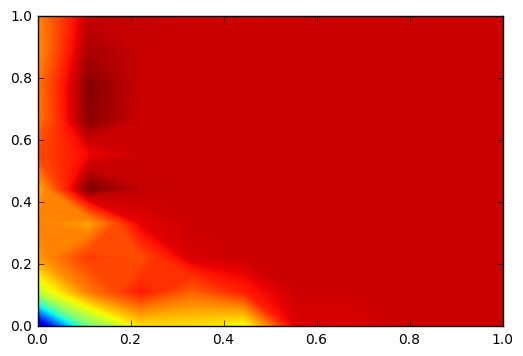

In [74]:
plt.contourf(X, Y, Z, 1000)
plt.show()

Как видим, в данной задаче регуляризацию лучше не использовать - наилучшая ошибка (после 10 итераций) при параметрах (0; 0) (при использовании более мелкого разбиения результат тот же)

### Булевы функции

1) AND характеризуется тем, что он истинен, тогда и только тогда, когда все его аргументы истинны, OR - когда хотя бы один, иными словами, AND возвращает TRUE когда из 2-х операндов 2 единички, OR - хотя бы одна. Тогда введем $w = (1, 1)$, при домножении на который мы и получим число единиц, а в качестве b для AND можно взять 1,5 (т.к. в функции Хевисайда нестрогое неравенство, можно взять и 2), а в случае OR $b = 1+ (-0.5)$. 

В случае произвольной размерности n в качестве w можно взять $(1)^n$, в качестве b для AND можно взять $n+(-0.5)$ и для OR $1+(-0.5)$

С not немного непонятно - это же унарный оператор, т.е. x - просто число, 0 или 1, и нам нужно выразить $x <= 0.5$, тогда в качестве w подойдет $-1$, а в качестве b подойдет $-0.5$

Если же имеются ввиду выражения вида $\neg x \wedge y$ и т.д., то они представимы в данном виде - заметим, что таблица истинности таких выражений имеет либо ровно одну 1, либо один 0, т.е. на плоскости у нас есть квадрат из 4 точек $(0,0), (0,1), (1,0), (1,1)$ и нам нужно отделить лишь одну от всех остальных - а это просто ($\neg x \wedge y$, например, разделяет $w =(-1, 1)$ и $b = -0.5$, в большоей размерности всё аналогично)

2) Легко понять, что XOR не может быть представлена в таком виде, т.к. точки $a = (0,0), b = (1,1)$ и $c = (0,1), d = (1,0)$ не могут быть разделены прямой, т.к. если a и b лежат по одну сторону от прямой, то c и d никак не могут оказаться обе и по другую сторону.

### 2 часть

Теперь мы имеем суперпозицию двух функций $\theta$, в таком виде мы уже можем реализовать и XOR, и любую булеву функцию. Т.к. мы можем представлять любую функцию в виде ДНФ(или КНФ), а затем записать эти формулы, так, что одной скобке соответсвующей формы соответсвует строчка матрицы $W_1$. Тогда в $W_1 x + b_1$ у нас будут записаны значения скобок ДНФ(или КНФ), и нам остается лишь взять их дизъюнкцию/конъюнкцию.

## Keras

In [33]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, RMSprop, adadelta

In [36]:
train_set = train_set[:, :-1]
test_set = test_set[:, :-1]

In [8]:
model = Sequential()
model.add(Dense(784, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

history = model.fit(train_set, train_labels,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(test_set, test_labels))
score = model.evaluate(test_set, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

(60000, 785)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 784)           615440      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 784)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 10)            7850        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 10)            0           dense_2[0][0]                    
Total params: 623290
_________________________________________________________

Точность стала лучше

### Зависимость качества от размера выхода первого слоя

Проварьируем размерность выхода первого слоя по степеням двойки

In [17]:
accuracies = []
sizes = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048)
for i in sizes:
    model = Sequential()
    model.add(Dense(i, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    history = model.fit(train_set, train_labels,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(test_set, test_labels))
    score = model.evaluate(test_set, test_labels, verbose=0)
    accuracies.append(score[1])

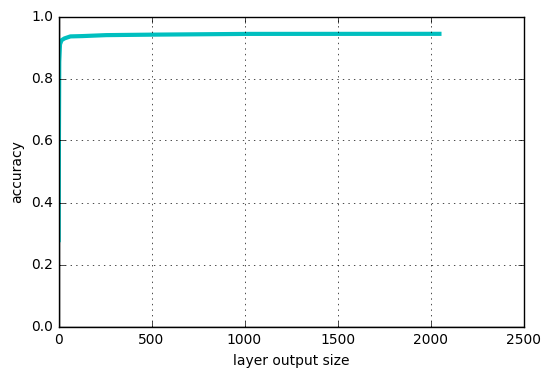

In [22]:
plt.grid(True)
plt.axhline(0, color="black")
plt.xlabel('layer output size')
plt.axvline(0, color="black")
plt.ylabel('accuracy')
plt.plot(sizes, accuracies, 'c', linewidth=3)
plt.show()

Точность монотонно возрастает от выходного размера после линейного преобразования, но с увеличением размерности выходного вектора увеличивается сложность вычислений

### Собственная архитектура

Я решил не сжимать картинки, а подавать фичи как есть, плюс добавить еще один слой и дропаут, серьезного прироста не вышло

In [37]:
model = Sequential()
model.add(Dense(784, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(784))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

history = model.fit(train_set, train_labels,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(test_set, test_labels))
score = model.evaluate(test_set, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_88 (Dense)                 (None, 784)           615440      dense_input_41[0][0]             
____________________________________________________________________________________________________
activation_88 (Activation)       (None, 784)           0           dense_88[0][0]                   
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 784)           0           activation_88[0][0]              
____________________________________________________________________________________________________
dense_89 (Dense)                 (None, 784)           615440      dropout_15[0][0]                 
___________________________________________________________________________________________

Исследуем качество на зависимость от числа слоев(количество эпох неизменное - 20)

In [39]:
accuracies = []
for add_layers_number in range(7):
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    for i in range(add_layers_number):
        model.add(Dropout(0.2))
        model.add(Dense(512))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),
                  metrics=['accuracy'])

    history = model.fit(train_set, train_labels,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(test_set, test_labels))
    score = model.evaluate(test_set, test_labels, verbose=0)
    accuracies.append(score[1])

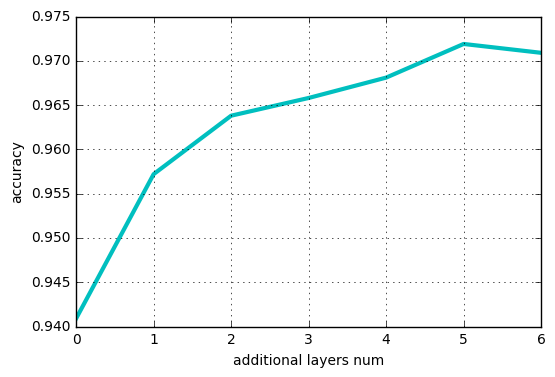

In [43]:
plt.grid(True)
plt.xlabel('additional layers num')
plt.ylabel('accuracy')
plt.plot(np.array(range(7)), accuracies, 'c', linewidth=3)
plt.show()

В нашем примере увеличение числа слоев ведет к улучшению качества вплоть до 5 дополнительных слоев, при увеличение числа дополнительных слоев до 6 качество немного ухудшилось.